In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, DateType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

# Inicijalizacija Spark sesije
spark = SparkSession.builder.appName("StockLinearRegression").getOrCreate()

# Definisanje seme koja ce se koristiti za podatke
schema = StructType([
    StructField("Date", DateType(), True),
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Volume", DoubleType(), True),
])

# Citanje podataka iz fajlova koji se nalaze na zadatoj putanji pomocu spark streaming-a
streaming_df = spark.readStream \
    .option("header", "true") \
    .schema(schema) \
    .csv("dbfs:/FileStore/stocks/")

# Sladistenje podataka u memoriji i to pod imenom upita 'msft_prices'
query = streaming_df.writeStream \
    .queryName("msft_prices") \
    .format("memory") \
    .outputMode("append") \
    .start()

In [ ]:
# Zaustavljanje pisanja
query.stop()

In [ ]:
# Ispis sta je upisano u memoriju
df = spark.table("msft_prices")
df.show()

+----------+-------+--------+--------+------+-----------+
|      Date|   Open|    High|     Low| Close|     Volume|
+----------+-------+--------+--------+------+-----------+
|2024-01-17| 387.98|  390.11|  384.81|389.47|2.2234108E7|
|2024-01-16| 393.66|  394.03|387.6229|390.27|2.7202268E7|
|2024-01-12| 385.49|  388.68|  384.65|388.47|2.1661153E7|
|2024-01-11|  386.0|  390.68|  380.38|384.63|2.7850846E7|
|2024-01-10| 376.37|  384.17|  376.32|382.77|2.5514245E7|
|2024-01-09| 372.01|  375.99|  371.19|375.79|2.0829953E7|
|2024-01-08|  369.3|   375.2|  369.01|374.69|2.3133967E7|
|2024-01-05| 368.97|  372.06|   366.5|367.75|2.0074451E7|
|2024-01-04|370.665|   373.1|  367.17|367.94|2.0901502E7|
|2024-01-03| 369.01|373.2562|  368.51| 370.6|2.3083465E7|
|2024-01-02| 373.86|   375.9| 366.771|370.87|2.5258633E7|
|2023-12-29|  376.0|  377.16|  373.48|376.04|1.8730838E7|
|2023-12-28| 375.37| 376.458|  374.16|375.28|1.4327013E7|
|2023-12-27| 373.69|  375.06|372.8116|374.07|1.4872756E7|
|2023-12-26|  

In [ ]:
# Zaustavljanje spark streaming-a
spark.stop()

+----------+------+------+------+------+---------+------------------+
|      Date|  Open|  High|   Low| Close|   Volume|      HighLowRange|
+----------+------+------+------+------+---------+------------------+
|1999-11-23| 89.25| 91.37| 88.37| 89.62|3.53937E7|               3.0|
|1999-11-24| 89.56| 92.25|  89.5| 91.69|2.68855E7|              2.75|
|1999-11-26| 91.62| 93.37|  91.0| 91.12|1.42571E7|2.3700000000000045|
|1999-11-29| 90.12| 92.06|  89.5| 90.19|2.57301E7|2.5600000000000023|
|1999-11-30| 89.75| 92.87| 89.56| 91.05|3.20728E7|3.3100000000000023|
|1999-12-01| 91.06| 93.94| 90.87| 93.19|2.44321E7| 3.069999999999993|
|1999-12-02| 93.06| 95.25| 92.87| 94.81|2.77369E7|2.3799999999999955|
|1999-12-03| 95.81| 97.12| 95.73| 96.12|3.20503E7|1.3900000000000006|
|1999-12-06| 95.25| 97.19| 94.75| 95.44|2.45491E7|2.4399999999999977|
|1999-12-07| 94.75| 94.87| 92.87|  93.0|2.84296E7|               2.0|
|1999-12-08| 93.12| 94.31| 91.69| 91.75|2.04779E7|2.6200000000000045|
|1999-12-09|  92.0| 

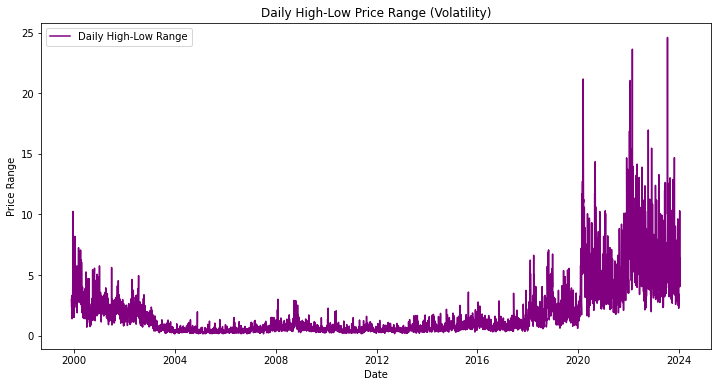

In [ ]:
from pyspark.sql.functions import dayofweek,  collect_list
import scipy.stats as stats
import pandas as pd

df = spark.table("msft_prices")
df = df.orderBy("Date")

# High-Low Price Range (Volatility) -  promenljivosti cena Microsoftovih akcija
# Analiza se fokusira na dnevni raspon cene - razliku između najviše i najniže cene u jednom danu
# raspon cene je mera volatilnosti - veći raspon ukazuje na veću volatilnost tog dana.
df = df.withColumn("HighLowRange", col("High") - col("Low"))
df_pd = df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(df_pd['Date'], df_pd['HighLowRange'], label='Daily High-Low Range', color='purple')
plt.xlabel('Date')
plt.ylabel('Price Range')
plt.title('Daily High-Low Price Range (Volatility)')
plt.legend()
plt.show()


# Cilj ove analize je kvantifikovati i vizualizovati dnevnu volatilnost akcija Microsofta. Volatilnost je ključni pokazatelj rizika i nestabilnosti na tržištu. Investitori i analitičari koriste ovakve analize za procenu rizika ulaganja u određenu akciju i za razumevanje tržišnih trendova.

In [ ]:
# Ova analiz sluzi kako bismo identifikovali trendove u cenama akcija Microsofta i procenili tržišnu dinamiku.

import pandas as pd

df = df.orderBy("Date", ascending=True)
pandas_df = df.toPandas()
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])

# Izracunavanje pokretni proseka
pandas_df['MA10'] = pandas_df['High'].rolling(window=10).mean() # 10-dnevni pokretni prosjek
pandas_df['MA50'] = pandas_df['High'].rolling(window=50).mean() # 50-dnevni pokretni prosjek
pandas_df['MA200'] = pandas_df['High'].rolling(window=200).mean() # 200-dnevni pokretni prosjek


# Vizualizacija
import plotly.graph_objects as go

fig = go.Figure()

# Dodavanje high cena
fig.add_trace(go.Scatter(x=pandas_df['Date'], y=pandas_df['High'], mode='lines', name='High'))

# Dodavanje pokretnih proseka
fig.add_trace(go.Scatter(x=pandas_df['Date'], y=pandas_df['MA10'], mode='lines', name='MA10'))
fig.add_trace(go.Scatter(x=pandas_df['Date'], y=pandas_df['MA50'], mode='lines', name='MA50'))
fig.add_trace(go.Scatter(x=pandas_df['Date'], y=pandas_df['MA200'], mode='lines', name='MA200'))

# Ažuriranje layout-a
fig.update_layout(title='Microsoft Stock Price with Moving Averages',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible=False)

fig.show()



+--------------------+--------+
|            features|     Low|
+--------------------+--------+
|[294.05,293.698,2...| 287.165|
|[287.165,294.05,2...|  278.53|
|[278.53,287.165,2...|   270.0|
|[270.0,278.53,287...|  280.78|
|[280.78,270.0,278...|  280.58|
|[280.58,280.78,27...|  279.43|
|[279.43,280.58,28...|  275.82|
|[275.82,279.43,28...| 278.725|
|[278.725,275.82,2...|   283.2|
|[283.2,278.725,27...|  289.37|
|[289.37,283.2,278...|  292.73|
|[292.73,289.37,28...|   294.9|
|[294.9,292.73,289...|  298.77|
|[298.77,294.9,292...|297.7201|
|[297.7201,298.77,...| 298.315|
|[298.315,297.7201...|299.2855|
|[299.2855,298.315...|  304.33|
|[304.33,299.2855,...|  309.05|
|[309.05,304.33,29...|  311.58|
|[311.58,309.05,30...|  307.89|
+--------------------+--------+
only showing top 20 rows



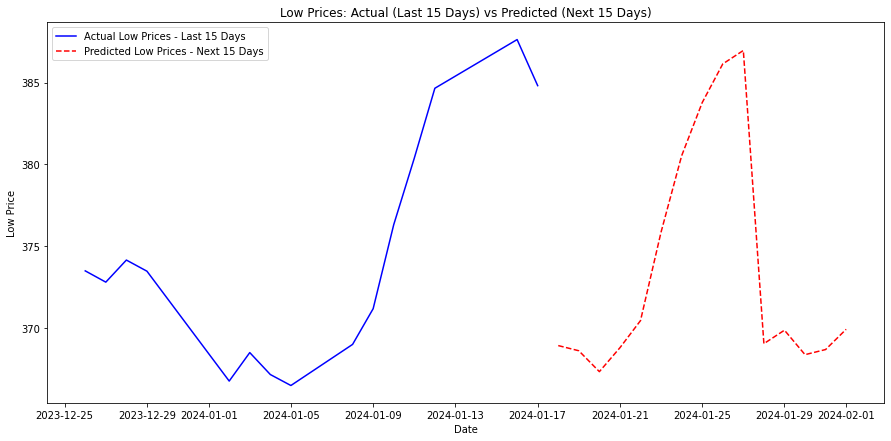

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import pandas as pd


# Ovde dodajemo nove kolone u nas DataFrame kako bismo imali koliki je prosek low cena u prethodnih 10dana, lag1, lag2, lag3...
num_lags = 10
num_future_days = 15
for i in range(1, num_lags + 1):
    df = df.withColumn(f"lag_{i}", lag("Low", i).over(Window.orderBy("Date")))


#Izbacujemo redove sa null vrednostima
df = df.na.drop()

# Grupisemo sve lag-ove u jednu kolonu koju cemo koristiti za model
# df_final ->
#       |features|        |Low|
# +--------------------+--------+
# |[294.05,293.698,2...| 287.165|
vectorAssembler = VectorAssembler(inputCols=[f"lag_{i}" for i in range(1, num_lags + 1)], outputCol="features")
df_vector = vectorAssembler.transform(df)
df_final = df_vector.select("features", "Low")
df_final.show()

# Treniranje modela
lr = LinearRegression(featuresCol="features", labelCol="Low")
lr_model = lr.fit(df_final)


# Priprema podataka za predvidjanje i vizuelizaciju
# Uzima se poslednji 10 poznatih podataka
last_rows = df.orderBy("Date", ascending=False).take(num_lags)
# Uzima samo low price iz celog reda i sortira podatke tako da su hronoloski poredjani  (od najstarijeg do najnovijeg).
last_features = [row.Low for row in last_rows][::-1]

future_predictions = []

# Predvidja vrednosti u narednih 15 dana na osnovu prethodnih
for _ in range(num_future_days):
    last_features_vector = Vectors.dense(last_features[-num_lags:])
    last_features_df = spark.createDataFrame([(last_features_vector,)], ["features"])
    next_prediction = lr_model.transform(last_features_df).collect()[0]['prediction']
    future_predictions.append(next_prediction)
    last_features.append(next_prediction)


# Uzimanje poslednji 15 dana koji su nam poznati i kod za vizuelizaciju
df_pd = df.orderBy("Date").toPandas()
last_15_days_df_pd = df_pd.tail(15)

last_actual_date = last_15_days_df_pd['Date'].iloc[-1]
future_dates = [last_actual_date + pd.DateOffset(days=i) for i in range(1, num_future_days + 1)]

plt.figure(figsize=(15, 7))
plt.plot(last_15_days_df_pd['Date'], last_15_days_df_pd['Low'], label='Actual Low Prices - Last 15 Days', color='blue')
plt.plot(future_dates, future_predictions, label='Predicted Low Prices - Next 15 Days', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Low Price')
plt.title('Low Prices: Actual (Last 15 Days) vs Predicted (Next 15 Days)')
plt.legend()
plt.show()
